# 1st and Future - Player Contact Detection

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import time
from sklearn.metrics import matthews_corrcoef

## Load data
> The description of the data can be found at the kaggle competition: https://www.kaggle.com/competitions/nfl-player-contact-detection/data

In [13]:
DATASET_DIR = "dataset"

# player tracking
train_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "train_player_tracking.csv"), 
                                       parse_dates=["datetime"])
test_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "test_player_tracking.csv"), 
                                      parse_dates=["datetime"])

# helmet detection
train_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))
test_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "test_baseline_helmets.csv"))

# video metadata
train_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "train_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])
test_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "test_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

### Check the player tracking dataframe

In [14]:
train_player_tracking_df.head()

game_play  game_key  play_id  nfl_player_id  \
0  58580_001136     58580     1136          44830   
1  58580_001136     58580     1136          47800   
2  58580_001136     58580     1136          52444   
3  58580_001136     58580     1136          46206   
4  58580_001136     58580     1136          52663   

                          datetime  step  team position  jersey_number  \
0 2021-10-10 21:08:20.900000+00:00  -108  away       CB             22   
1 2021-10-10 21:08:20.900000+00:00  -108  away       DE             97   
2 2021-10-10 21:08:20.900000+00:00  -108  away       FS             29   
3 2021-10-10 21:08:20.900000+00:00  -108  home       TE             86   
4 2021-10-10 21:08:20.900000+00:00  -108  away      ILB             48   

   x_position  y_position  speed  distance  direction  orientation  \
0       61.59       42.60   1.11      0.11     320.33       263.93   
1       59.48       26.81   0.23      0.01     346.84       247.16   
2       72.19       31.46   0.61      0.06      11.77       247.69   
3       57.37       22.12   0.37      0.04     127.85        63.63   
4       63.25       27.50   0.51      0.05     183.62       253.71   

   acceleration    sa  
0          0.71 -0.64  
1          1.29  0.90  
2          0.63 -0.33  
3          0.69  0.62  
4          0.31  0.31

In [15]:
train_player_tracking_df.describe()

game_key       play_id  nfl_player_id          step  jersey_number  \
count  1.353053e+06  1.353053e+06   1.353053e+06  1.353053e+06   1.353053e+06   
mean   5.836580e+04  2.156408e+03   4.474702e+04 -1.190047e+01   5.128245e+01   
std    1.376961e+02  1.211457e+03   4.831883e+03  1.125495e+02   2.863610e+01   
min    5.816800e+04  4.000000e+01   2.551100e+04 -3.390000e+02   1.000000e+00   
25%    5.822500e+04  1.016000e+03   4.235200e+04 -8.600000e+01   2.500000e+01   
50%    5.833000e+04  2.369000e+03   4.489300e+04 -1.500000e+01   5.200000e+01   
75%    5.851600e+04  3.139000e+03   4.781400e+04  4.900000e+01   7.600000e+01   
max    5.858200e+04  4.644000e+03   5.398500e+04  6.920000e+02   9.900000e+01   

         x_position    y_position         speed      distance     direction  \
count  1.353053e+06  1.353053e+06  1.353053e+06  1.353053e+06  1.353053e+06   
mean   6.030805e+01  2.675891e+01  1.259892e+00  1.287081e-01  1.796989e+02   
std    2.681538e+01  8.507395e+00  1.658213e+00  1.666470e-01  1.040005e+02   
min   -7.470000e+00 -1.287000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.848000e+01  2.249000e+01  1.200000e-01  2.000000e-02  9.003000e+01   
50%    5.969000e+01  2.674000e+01  6.500000e-01  7.000000e-02  1.792400e+02   
75%    8.171000e+01  3.104000e+01  1.620000e+00  1.600000e-01  2.693300e+02   
max    1.256500e+02  6.372000e+01  1.489000e+01  2.220000e+00  3.600000e+02   

        orientation  acceleration            sa  
count  1.353053e+06  1.353053e+06  1.353053e+06  
mean   1.802823e+02  7.931542e-01 -6.756010e-02  
std    9.950983e+01  9.568293e-01  9.922022e-01  
min    0.000000e+00  0.000000e+00 -2.310000e+01  
25%    8.994000e+01  1.500000e-01 -3.800000e-01  
50%    1.802300e+02  4.700000e-01 -3.000000e-02  
75%    2.701700e+02  1.040000e+00  1.600000e-01  
max    3.600000e+02  3.355000e+01  3.355000e+01

In [16]:
train_player_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353053 entries, 0 to 1353052
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   game_play      1353053 non-null  object             
 1   game_key       1353053 non-null  int64              
 2   play_id        1353053 non-null  int64              
 3   nfl_player_id  1353053 non-null  int64              
 4   datetime       1353053 non-null  datetime64[ns, UTC]
 5   step           1353053 non-null  int64              
 6   team           1353053 non-null  object             
 7   position       1353053 non-null  object             
 8   jersey_number  1353053 non-null  int64              
 9   x_position     1353053 non-null  float64            
 10  y_position     1353053 non-null  float64            
 11  speed          1353053 non-null  float64            
 12  distance       1353053 non-null  float64            
 13  direction   

### Check the helmet detection dataframe

In [17]:
train_helmet_detection_df.head()

game_play  game_key  play_id     view                     video  frame  \
0  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
1  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
2  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
3  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
4  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   

   nfl_player_id player_label  left  width  top  height  
0          39947          H72   946     25  293      34  
1          37211          H42   151     25  267      33  
2          38590          H70   810     25  293      35  
3          44822          H15   681     26  254      33  
4          41944          V92   680     23  303      33

In [18]:
train_helmet_detection_df.describe()

game_key       play_id         frame  nfl_player_id          left  \
count  3.783616e+06  3.783616e+06  3.783616e+06   3.783616e+06  3.783616e+06   
mean   5.837021e+04  2.186813e+03  5.176293e+02   4.492682e+04  6.295490e+02   
std    1.396644e+02  1.195722e+03  1.569070e+02   4.762725e+03  2.665431e+02   
min    5.816800e+04  4.000000e+01  2.890000e+02   2.551100e+04  0.000000e+00   
25%    5.822700e+04  1.076000e+03  3.920000e+02   4.237200e+04  4.440000e+02   
50%    5.833200e+04  2.375000e+03  4.970000e+02   4.492600e+04  6.320000e+02   
75%    5.852400e+04  3.151000e+03  6.170000e+02   4.782500e+04  8.150000e+02   
max    5.858200e+04  4.644000e+03  1.326000e+03   5.398500e+04  1.278000e+03   

              width           top        height  
count  3.783616e+06  3.783616e+06  3.783616e+06  
mean   1.794553e+01  3.050392e+02  1.902664e+01  
std    8.656632e+00  1.192583e+02  9.384617e+00  
min    2.000000e+00  0.000000e+00  2.000000e+00  
25%    1.100000e+01  2.350000e+02  1.200000e+01  
50%    1.600000e+01  3.010000e+02  1.700000e+01  
75%    2.400000e+01  3.720000e+02  2.500000e+01  
max    8.200000e+01  7.180000e+02  8.900000e+01

In [19]:
train_helmet_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3783616 entries, 0 to 3783615
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   game_play      object
 1   game_key       int64 
 2   play_id        int64 
 3   view           object
 4   video          object
 5   frame          int64 
 6   nfl_player_id  int64 
 7   player_label   object
 8   left           int64 
 9   width          int64 
 10  top            int64 
 11  height         int64 
dtypes: int64(8), object(4)
memory usage: 346.4+ MB


### Check the video metadata dataframe

In [20]:
train_video_metadata_df.head()

game_play  game_key  play_id      view                       start_time  \
0  58168_003392     58168     3392   Endzone 2020-09-11 03:01:43.134000+00:00   
1  58168_003392     58168     3392  Sideline 2020-09-11 03:01:43.134000+00:00   
2  58172_003247     58172     3247   Endzone 2020-09-13 19:30:42.414000+00:00   
3  58172_003247     58172     3247  Sideline 2020-09-13 19:30:42.414000+00:00   
4  58173_003606     58173     3606   Endzone 2020-09-13 19:45:07.527000+00:00   

                          end_time                        snap_time  
0 2020-09-11 03:01:54.971000+00:00 2020-09-11 03:01:48.134000+00:00  
1 2020-09-11 03:01:54.971000+00:00 2020-09-11 03:01:48.134000+00:00  
2 2020-09-13 19:31:00.524000+00:00 2020-09-13 19:30:47.414000+00:00  
3 2020-09-13 19:31:00.524000+00:00 2020-09-13 19:30:47.414000+00:00  
4 2020-09-13 19:45:26.438000+00:00 2020-09-13 19:45:12.527000+00:00

In [21]:
train_video_metadata_df.describe(include="all", datetime_is_numeric=True)

game_play      game_key      play_id     view  \
count            480    480.000000   480.000000      480   
unique           240           NaN          NaN        2   
top     58168_003392           NaN          NaN  Endzone   
freq               2           NaN          NaN      240   
mean             NaN  58370.787500  2177.420833      NaN   
min              NaN  58168.000000    40.000000      NaN   
25%              NaN  58231.500000  1077.500000      NaN   
50%              NaN  58331.500000  2348.500000      NaN   
75%              NaN  58521.000000  3125.500000      NaN   
max              NaN  58582.000000  4644.000000      NaN   
std              NaN    139.613935  1200.568541      NaN   

                                 start_time  \
count                                   480   
unique                                  NaN   
top                                     NaN   
freq                                    NaN   
mean    2021-02-24 22:10:23.570112512+00:00   
min        2020-09-11 03:01:43.134000+00:00   
25%     2020-10-11 18:04:45.717750016+00:00   
50%     2020-11-29 19:27:53.588499968+00:00   
75%     2021-09-19 17:09:15.293000192+00:00   
max        2021-10-12 02:42:15.078000+00:00   
std                                     NaN   

                                   end_time  \
count                                   480   
unique                                  NaN   
top                                     NaN   
freq                                    NaN   
mean    2021-02-24 22:10:36.502428928+00:00   
min        2020-09-11 03:01:54.971000+00:00   
25%        2020-10-11 18:04:59.388000+00:00   
50%     2020-11-29 19:28:07.249999872+00:00   
75%     2021-09-19 17:09:27.694999808+00:00   
max        2021-10-12 02:42:29.118000+00:00   
std                                     NaN   

                                  snap_time  
count                                   480  
unique                                  NaN  
top                                     NaN  
freq                                    NaN  
mean    2021-02-24 22:10:28.570099968+00:00  
min        2020-09-11 03:01:48.134000+00:00  
25%     2020-10-11 18:04:50.717750016+00:00  
50%     2020-11-29 19:27:58.588499968+00:00  
75%     2021-09-19 17:09:20.293000192+00:00  
max        2021-10-12 02:42:20.078000+00:00  
std                                     NaN

In [22]:
train_video_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   game_play   480 non-null    object             
 1   game_key    480 non-null    int64              
 2   play_id     480 non-null    int64              
 3   view        480 non-null    object             
 4   start_time  480 non-null    datetime64[ns, UTC]
 5   end_time    480 non-null    datetime64[ns, UTC]
 6   snap_time   480 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), int64(2), object(2)
memory usage: 26.4+ KB


### Check the train labels dataframe

In [23]:
train_labels_df.head()

contact_id     game_play                         datetime  \
0  58168_003392_0_38590_43854  58168_003392 2020-09-11 03:01:48.100000+00:00   
1  58168_003392_0_38590_41257  58168_003392 2020-09-11 03:01:48.100000+00:00   
2  58168_003392_0_38590_41944  58168_003392 2020-09-11 03:01:48.100000+00:00   
3  58168_003392_0_38590_42386  58168_003392 2020-09-11 03:01:48.100000+00:00   
4  58168_003392_0_38590_47944  58168_003392 2020-09-11 03:01:48.100000+00:00   

   step  nfl_player_id_1 nfl_player_id_2  contact  
0     0            38590           43854        0  
1     0            38590           41257        0  
2     0            38590           41944        0  
3     0            38590           42386        0  
4     0            38590           47944        0

In [24]:
train_labels_df.describe(include="all", datetime_is_numeric=True)

contact_id     game_play  \
count                      4721618       4721618   
unique                     4721618           240   
top     58168_003392_0_38590_43854  58537_000757   
freq                             1         43769   
mean                           NaN           NaN   
min                            NaN           NaN   
25%                            NaN           NaN   
50%                            NaN           NaN   
75%                            NaN           NaN   
max                            NaN           NaN   
std                            NaN           NaN   

                                   datetime          step  nfl_player_id_1  \
count                               4721618  4.721618e+06     4.721618e+06   
unique                                  NaN           NaN              NaN   
top                                     NaN           NaN              NaN   
freq                                    NaN           NaN              NaN   
mean    2021-02-23 13:03:45.332655104+00:00  4.074472e+01     4.249579e+04   
min        2020-09-11 03:01:48.100000+00:00  0.000000e+00     2.551100e+04   
25%        2020-10-04 21:24:56.600000+00:00  1.900000e+01     4.007000e+04   
50%        2020-11-29 18:08:21.100000+00:00  3.800000e+01     4.266700e+04   
75%        2021-09-17 03:13:29.400000+00:00  5.900000e+01     4.500500e+04   
max        2021-10-12 02:42:29.100000+00:00  1.720000e+02     5.398500e+04   
std                                     NaN  2.683546e+01     4.342500e+03   

       nfl_player_id_2       contact  
count          4721618  4.721618e+06  
unique            1646           NaN  
top                  G           NaN  
freq            410633           NaN  
mean               NaN  1.366523e-02  
min                NaN  0.000000e+00  
25%                NaN  0.000000e+00  
50%                NaN  0.000000e+00  
75%                NaN  0.000000e+00  
max                NaN  1.000000e+00  
std                NaN  1.160969e-01

In [25]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721618 entries, 0 to 4721617
Data columns (total 7 columns):
 #   Column           Dtype              
---  ------           -----              
 0   contact_id       object             
 1   game_play        object             
 2   datetime         datetime64[ns, UTC]
 3   step             int64              
 4   nfl_player_id_1  int64              
 5   nfl_player_id_2  object             
 6   contact          int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 252.2+ MB


* We can see that nfl_player_id_2	is an object and not an integer, as it can have the value 'G' to indicate a contact with the ground

## Utils

In [26]:
def array_to_image(image_array):
    """returns a PIL image converted from the given image array"""
    if len(image_array) == 0:
        return []
    return Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

In [27]:
def step_to_frame(game_play, step, metadata_df, view='Endzone'):
    meta_column = metadata_df[(metadata_df['game_play'] == game_play) &
                             (metadata_df['view'] == view)]
    seconds_to_start = (meta_column['snap_time'] - meta_column['start_time']).iloc[0].total_seconds()
    first_step = -seconds_to_start * 10
    steps_from_start = step - first_step
    seconds_from_start = steps_from_start/10
    frame_number = int(seconds_from_start*60)
    
    return frame_number

In [28]:
step_to_frame("58580_001136", 0, train_video_metadata_df, 'Endzone')

300

In [29]:
def get_video_frame(game_play, frame_number, view='Endzone', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    video_name = f"{game_play}_{view}.mp4"
    videopath = os.path.join(DATASET_DIR, split, video_name)
    cap = cv2.VideoCapture(videopath)
    res = False
    while res==False:
        # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
        frame_number = frame_number-1
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = cap.read()
    
    # correct 1 frame offset and return the image and the corrected frame_number as well
    frame_number += 1
    return frame, frame_number

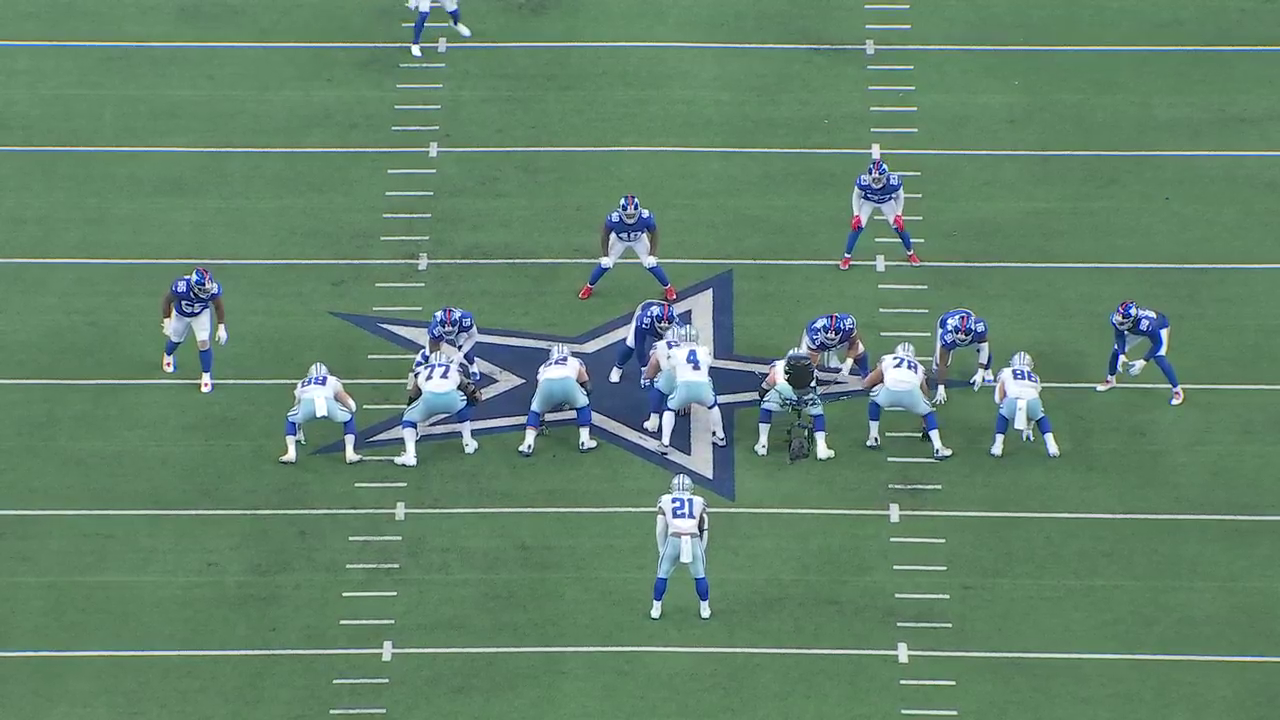

In [30]:
frame_number = step_to_frame("58580_001136", 0, train_video_metadata_df, 'Endzone')
array_to_image(get_video_frame("58580_001136", frame_number, 'Endzone', "train")[0])

In [31]:
def draw_boxes(boxes, labels, image, color=(0, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), # top-left corner
                     (int(box[2]), int(box[3])), # bottom-right corner
                     color, 2)
        # showing probability scores
        bbox_text = f"{labels[i]}" 
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, thickness=1,
                   lineType=cv2.LINE_AA)
    
    return image

In [32]:
def get_helmet_detections(helmet_detection_df, game_play, frame_number, view):
    
    detections = helmet_detection_df[(helmet_detection_df['frame'] == frame_number) & 
                            (helmet_detection_df['view'] == view) &
                            (helmet_detection_df['game_play'] == game_play)
                            ][['left', 'width', 'top', 'height', 'player_label']].values
    
    boxes, labels = detections[:, :-1], detections[:, -1]
    # convert boxes to standard format of:
    # [xmin, ymin, xmax, ymax]
    boxes_st = boxes.copy()
    boxes_st[:, 1] = boxes[:, 2] # ymin
    boxes_st[:, 2] = boxes[:, 0] + boxes[:, 1] # xmax
    boxes_st[:, 3] = boxes[:, 2] + boxes[:, 3] # ymax
    boxes = np.array(boxes).astype(int)
    labels = np.array(labels)
    
    return np.array(boxes_st), np.array(labels)

In [33]:
def draw_helmet_detection(helmet_detection_df, game_play, frame_number, view='Endzone', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view
    with the drawn detection boxes and labels.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    helmet_detection_df: the helmet detection dataframe
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    frame, correct_frame_number = get_video_frame(game_play, frame_number, view, split)
    boxes, labels = get_helmet_detections(helmet_detection_df, game_play, correct_frame_number, view)
    
    # draw the detection boxes
    frame = draw_boxes(boxes, labels, frame, color=(0,0,0))
    
    return frame

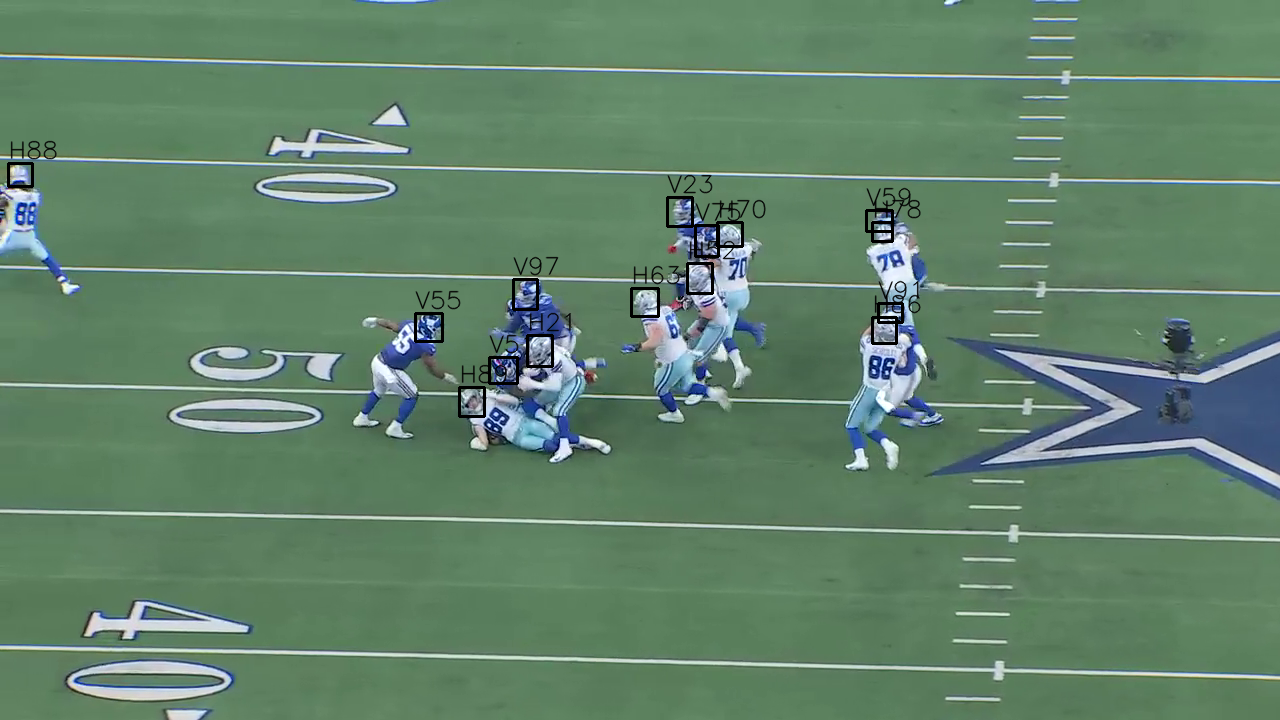

In [34]:
frame_number = step_to_frame("58580_001136", 30, train_video_metadata_df, 'Endzone')
array_to_image(draw_helmet_detection(train_helmet_detection_df, 
                                     "58580_001136", 
                                     frame_number, 
                                     'Endzone', 
                                     "train"))

## YOLO person detection

In [35]:
def get_yolo_detections(yolo_model, image, confidence=0.5):
    """
    Carries out object detection on the given image using the given yolo model.
    Only the detections with a higher confidence interval than the given value are returned.
    Returns a list of bounding box coordinates in the format: ['xmin', 'ymin', 'xmax', 'ymax']
    And a list of the class names of each bounding box.
    """
    results = yolo_model(image)
    results_df = results.pandas().xyxy[0]
    results_df = results_df[results_df['confidence'] > confidence]
    detections = results_df[['xmin', 'ymin', 'xmax', 'ymax', 'name']].values
    boxes, labels = detections[:, :-1], detections[:, -1]
    boxes = np.array(boxes).astype(int)
    labels = np.array(labels)
    
    return boxes, labels

In [40]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\AT016638/.cache\torch\hub\ultralytics_yolov5_master
requirements: YOLOv5 requirement "gitpython" not found, attempting AutoUpdate...
     -------------------------------------- 184.0/184.0 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.3 MB/s eta 0:00:00

requirements: 1 package updated per C:\Users\AT016638\.cache\torch\hub\ultralytics_yolov5_master\requirements.txt
requirements:  Restart runtime or rerun command for updates to take effect

YOLOv5  2023-1-2 Python-3.7.15 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)

100.0%

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


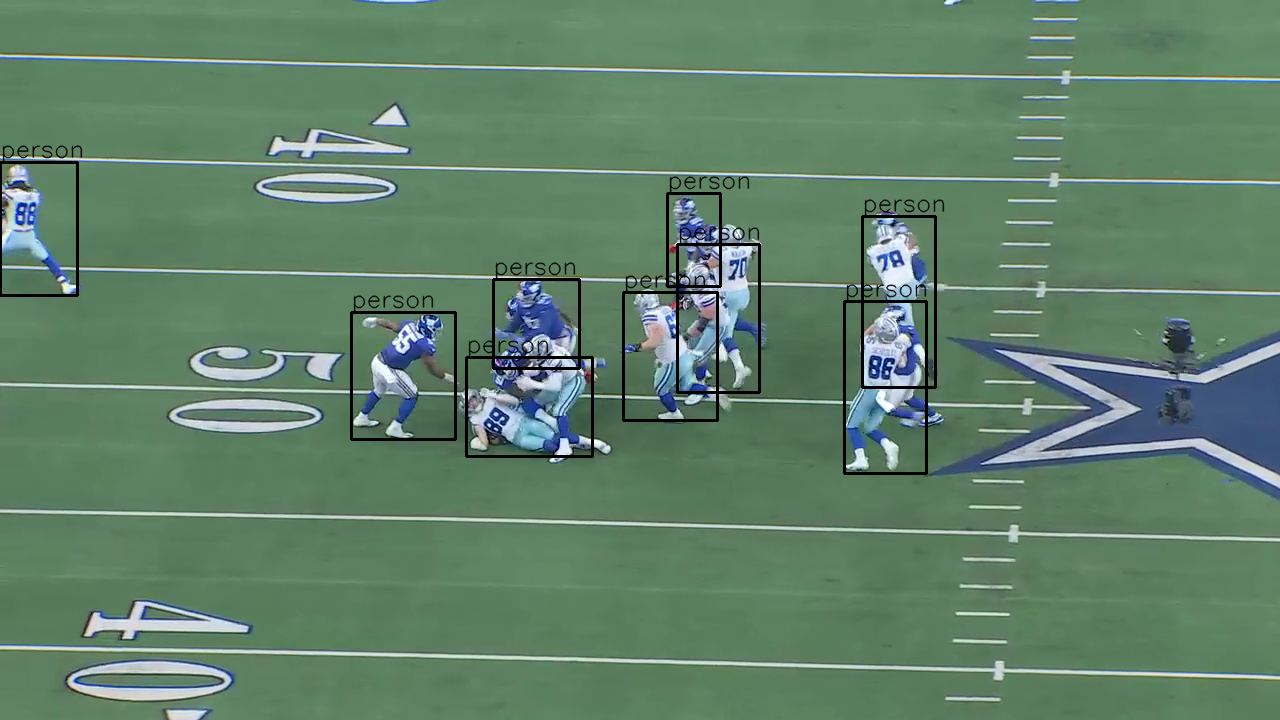

In [41]:
frame_number = step_to_frame("58580_001136", 30, train_video_metadata_df, 'Endzone')
image_array, frame_number = get_video_frame("58580_001136", frame_number, 'Endzone', "train")
image = array_to_image(image_array)
boxes, labels = get_yolo_detections(yolo_model, image, 0.3)
array_to_image(draw_boxes(boxes, labels, image_array))

## Crop image of 2 players

In [42]:
def get_player_label(game_play, player_id, tracking_df):
    """
    Returns the player label from the given player_id in the format of the helmet detection dataframe
    """
    # if the player is the ground, return 'G'
    if (player_id == -1 or player_id == 'G'):
        return 'G'
    
    col = tracking_df.loc[(tracking_df['game_play'] == game_play) & 
                         (tracking_df['nfl_player_id'] == player_id)].iloc[0]
    # get the player jersey number
    player_label = str(col['jersey_number'])
    # put V (away) or H (home) before the jersey number 
    if (col['team'] == 'away'):
        player_label = 'V'+player_label
    else:
        player_label = 'H'+player_label
        
    return player_label

In [43]:
get_player_label("58580_001136", 44830, train_player_tracking_df)

'V22'

In [44]:
def IOU(box_1, box_2):
    """
    Computes the Intersection Over Union (IOU) between two bounding boxes formatted as [x_min, y_min, x_max, y_max]
    """
    # get the right-most left edge between the two bounding boxes
    max_left = max(box_1[0], box_2[0])
    # get the left-most right edge between the two bounding boxes
    min_right = min(box_1[2], box_2[2])
    # compute the intersection width
    intersection_width = min_right - max_left
    
    # get the lowest top edge (y is bigger as it goes lower)
    max_top = max(box_1[1], box_2[1])
    # get the highest bottom edge
    min_bottom = min(box_1[3], box_2[3])
    # compute the intersection height
    intersection_height = min_bottom - max_top
    
    # if the boxes don't intersect, intersection_width or height will be negative
    intersection_area = max(0, intersection_width) * max(0, intersection_height)
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    # get the union area by adding the boxes areas and substracting their intersection
    union_area = box_1_area + box_2_area - intersection_area
    # get the final iou
    iou = intersection_area / union_area
    
    return iou

In [45]:
def filter_helmet_detection(game_play, boxes_helmet, labels_helmet,
                            player_ids, tracking_df):
    """
    From a list of helmet detections, return only the ones that pertain to the player ids
    """
    # get the player labels
    player_labels = [get_player_label(game_play, player_id, tracking_df) for player_id in player_ids]

    # filter the helmet boxes that have the labels from player 1 and 2
    boxes_helmet = boxes_helmet[np.in1d(labels_helmet, player_labels)]
    labels_helmet = labels_helmet[np.in1d(labels_helmet, player_labels)]
    
    return boxes_helmet, labels_helmet

In [46]:
def merge_boxes(box_1, box_2):
    """
    merges two boxes into a single one
    """
    merged_box = [min(box_1[0], box_2[0]), # xmin
                 min(box_1[1], box_2[1]),  # ymin
                 max(box_1[2], box_2[2]),  # xmax
                 max(box_1[3], box_2[3])]  # ymax
    
    return merged_box

In [47]:
def join_boxes_IOU(boxes_1, boxes_2, image_size, view):
    """
    Matches each box from the first set with the box from the second set with highest IOU
    and creates a joined box that contains the two boxes.
    box format: [x_min, y_min, x_max, y_max]
    """
    # average box sizes for each view found on the trainign set
    if(view == 'Endzone'):
        # endzone box averages
        AVG_BOX_WITH = 71 
        AVG_BOX_HEIGHT = 130
    else:
        # sideline box averages
        AVG_BOX_WITH = 40 
        AVG_BOX_HEIGHT = 81
    
    img_width, img_height = image_size
    merged_boxes = []
    num_correct_merges = 0
    for box_1 in boxes_1:
        max_iou = 0
        matched_box = []
        # for each box 1, find the box2 with highes iou
        for box_2 in boxes_2:
            iou = IOU(box_1, box_2)
            if iou > max_iou:
                max_iou = iou
                matched_box = box_2
        # if a matching box has been found, merge the two boxes.
        # if not, save the original box_1 + the average box width and height of the view
        if len(matched_box) !=0:
            merged_box = merge_boxes(box_1, matched_box)
            num_correct_merges += 1
        else:
            # add half the average box width to each side of the horizontal center of the helmet box
            x_center = round((box_1[2] + box_1[0]) / 2)
            x_min = max(0, x_center - round(AVG_BOX_WITH / 2))
            x_max = min(img_width, x_center + round(AVG_BOX_WITH / 2))
            # add the average height to y_max, y_min stays the same as it should be the top of the player head
            y_min = box_1[1]
            y_max = min(img_height, box_1[3] + AVG_BOX_HEIGHT)
            merged_box = [x_min, y_min, x_max, y_max]
        merged_boxes.append(merged_box)
    
    return merged_boxes, num_correct_merges

In [48]:
def get_contact_box(boxes_helmet, labels_helmet,
                    boxes_yolo, labels_yolo, image_size, view):
    """
    Returns the merged contact box between two players and the number of players correctly detected
    """
    # filter the yolo boxes that have "person" as a predicted label
    boxes_yolo = boxes_yolo[labels_yolo == 'person']
    
    # join helmet and person detections
    boxes_player, num_correct_merges =  join_boxes_IOU(boxes_helmet, boxes_yolo, 
                                                       image_size, view)
    
    # if 2 players have been detected, merge their boxes into one
    contact_box = []
    if len(boxes_player) == 2:
        contact_box = merge_boxes(boxes_player[0] , boxes_player[1])
    elif len(boxes_player) == 1:
        contact_box = boxes_player[0]
    
    return contact_box, num_correct_merges

In [49]:
def get_contact_image(game_play, player_id_1, 
                       player_id_2, step, yolo_model, 
                       metadata_df, helmet_detection_df, tracking_df,
                       view='Endzone', split="train", crop=True, max_rewind=120):
    
    frame_number = step_to_frame(game_play, step, metadata_df, view)
    image_array, frame_number = get_video_frame(game_play, frame_number, view, split)
    image = array_to_image(image_array)
    # get the helmet detection boxes and labels
    boxes_helmet, labels_helmet = get_helmet_detections(helmet_detection_df, game_play, frame_number, view)
    # get the yolo detection boxes and labels
    boxes_yolo, labels_yolo = get_yolo_detections(yolo_model, image, 0.3)
    # filter detections of the 2 players
    boxes_helmet, labels_helmet = filter_helmet_detection(game_play, boxes_helmet, 
                                                          labels_helmet, [player_id_1, player_id_2], 
                                                          tracking_df)
    
    # If no helmets where detected, rewind 10 frames at a time for a maximum of max_rewind frames
    # and look for helmet detections again
    rewinded_frames = 0
    while(len(labels_helmet) == 0 and rewinded_frames < max_rewind):
        rewinded_frames += 10
        # detect the helmets on the rewinded frame
        boxes_helmet, labels_helmet = get_helmet_detections(helmet_detection_df, game_play, 
                                                    frame_number-rewinded_frames, view)
        # filter detections of the 2 players
        boxes_helmet, labels_helmet = filter_helmet_detection(game_play, 
                                                            boxes_helmet, 
                                                            labels_helmet, 
                                                            [player_id_1, player_id_2], 
                                                            tracking_df)
    
    # get the contact box
    contact_box, num_dets = get_contact_box(boxes_helmet, labels_helmet,
                                        boxes_yolo, labels_yolo, image.size, view)
    
    # if no helmets have been detected, return empty image
    # TODO use tracking, check previous and next frames
    if len(contact_box) == 0:
        return []
    
    if crop:
        # crop the image
        image_array = image_array[contact_box[1]:contact_box[3], # y coordinates
                                  contact_box[0]:contact_box[2]] # x coordinates
    else:
        # if crop = False, draw the contact and helmets bounding boxes
        image_array = draw_boxes([contact_box], [''], image_array)
        image_array = draw_boxes(boxes_helmet, labels_helmet, image_array)
    
    
    return image_array

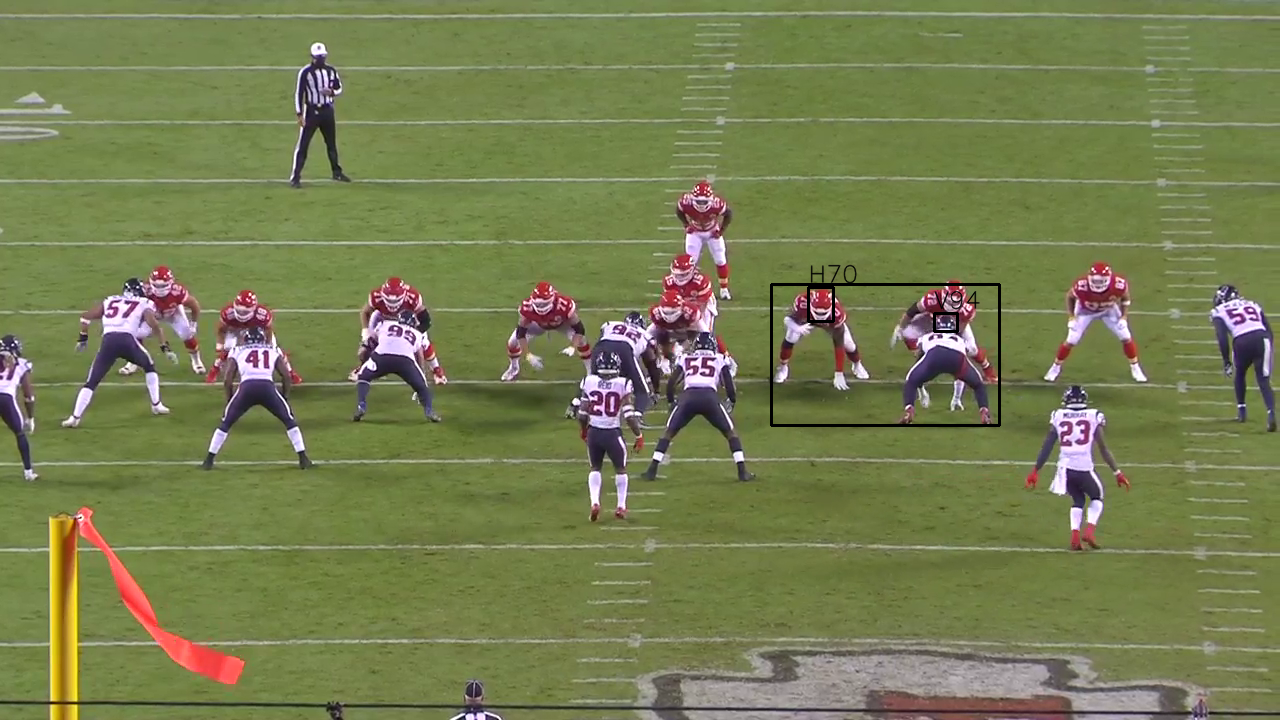

In [50]:
array_to_image(get_contact_image('58168_003392', 38590, 47944, 0, yolo_model, 
                   train_video_metadata_df, train_helmet_detection_df, 
                   train_player_tracking_df, 'Endzone', 'train', crop=False))

### Show bad cases
* Add average height and with from yolo detections to helmet detections if no yolo match (per view)

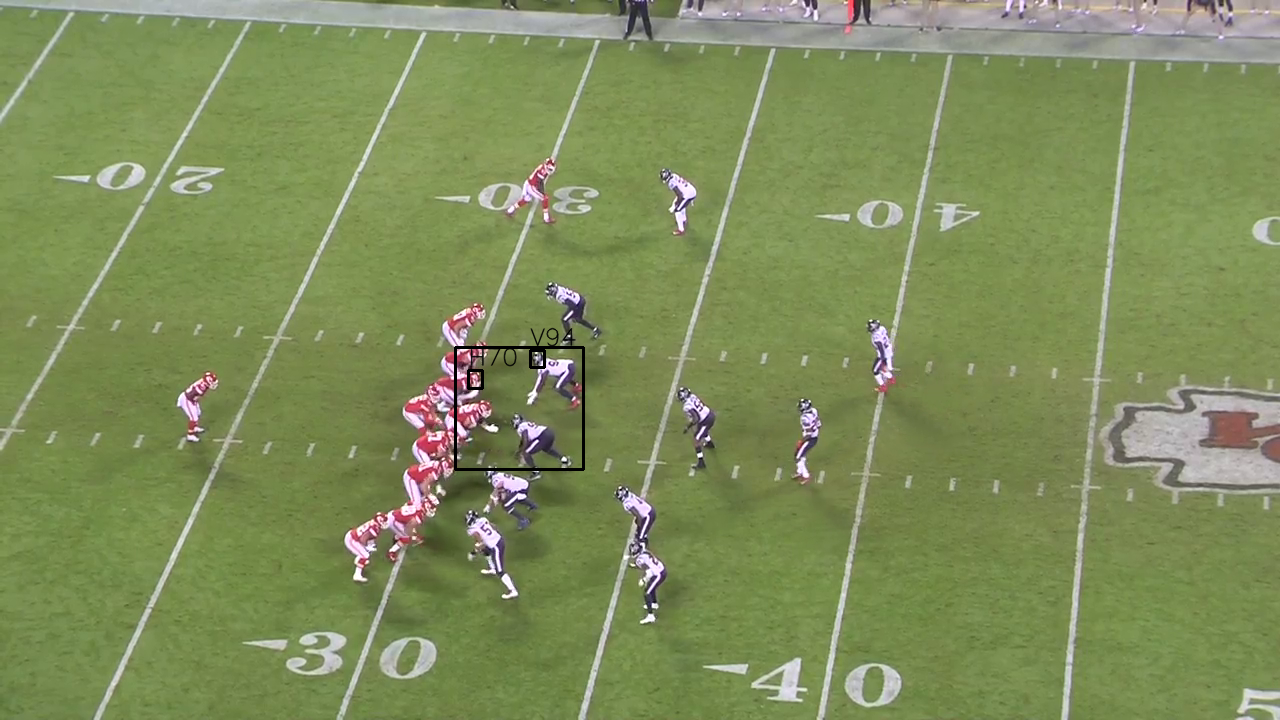

In [51]:
array_to_image(get_contact_image('58168_003392', 38590, 47944, 0, yolo_model, 
                   train_video_metadata_df, train_helmet_detection_df, 
                   train_player_tracking_df, 'Sideline', 'train', crop=False))

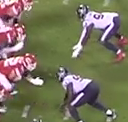

In [52]:
array_to_image(get_contact_image('58168_003392', 38590, 47944, 0, yolo_model, 
                   train_video_metadata_df, train_helmet_detection_df, 
                   train_player_tracking_df, 'Sideline', 'train', crop=True))

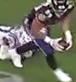

In [53]:
array_to_image(get_contact_image('58582_003121', 39971, -1, 87, yolo_model, 
                   train_video_metadata_df, train_helmet_detection_df, 
                   train_player_tracking_df, 'Sideline', 'train', crop=True))

V92
H62


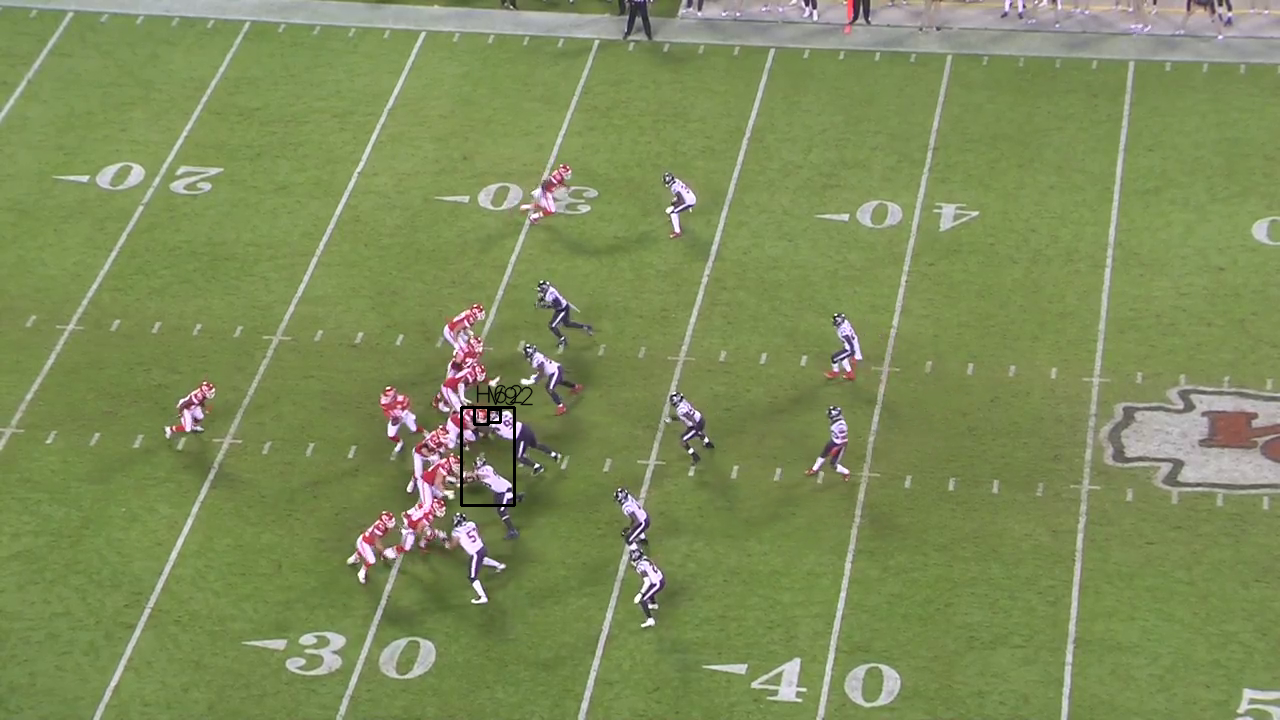

In [54]:
print(get_player_label("58168_003392", 41944, train_player_tracking_df))
print(get_player_label("58168_003392", 42565, train_player_tracking_df))
array_to_image(get_contact_image('58168_003392', 41944, 42565, 3, yolo_model, 
                   train_video_metadata_df, train_helmet_detection_df, 
                   train_player_tracking_df, 'Sideline', 'train', crop=False))

## Data Preprocessing
Extract the player to player distance and add tracking information to the input contact dataframe

### Extract the contact info

In [55]:
def extract_contact_id_info(input_df):
    # game_key, play_id, player_1_id, player_2_id, step
    contact_df = pd.DataFrame()
    split = input_df['contact_id'].str.split("_")
    contact_df['contact_id'] = input_df['contact_id']
    contact_df['game_play'] = split.str[0]+'_'+split.str[1]
    contact_df['step'] = split.str[2].astype("int")
    contact_df['nfl_player_id_1'] = split.str[3]
    contact_df['nfl_player_id_2'] = split.str[4]
    # replace ground 'G' players id with '-1'
    contact_df.loc[contact_df["nfl_player_id_2"] == 'G', 'nfl_player_id_2'] = '-1'
    contact_df['nfl_player_id_1'] = contact_df['nfl_player_id_1'].astype('int')
    contact_df['nfl_player_id_2'] = contact_df['nfl_player_id_2'].astype('int')
    
    return contact_df

In [56]:
def add_contact_tracking_info(contact_df, tracking_df):
    """
    Joins a contact dataframe with player tracking dataframe on both players
    """
    player_specific_columns=["team", "position", "jersey_number",
                              "x_position", "y_position", "speed", 
                              "distance", "direction", "orientation",
                              "acceleration", "sa"]
    # join on player 1
    contact_df = contact_df.merge(tracking_df, 
                                 left_on=['game_play', 'nfl_player_id_1', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop(["nfl_player_id"], axis=1, inplace=True)
    # rename player 1 specific tracking data
    contact_df.rename(columns=lambda x: x+'_1' if x in player_specific_columns else x, inplace=True)

    # join on player 2
    # avoid repeating the "game_key", "play_id", 'datetime' columns
    contact_df = contact_df.merge(tracking_df.drop(['game_key', 'play_id', 'datetime'], axis=1), 
                                 left_on=['game_play', 'nfl_player_id_2', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop("nfl_player_id", axis=1, inplace=True)
    # rename player 2 specific tracking data
    contact_df.rename(columns=lambda x: x+'_2' if x in player_specific_columns else x, inplace=True)
    contact_df.replace(np.nan, 0, inplace=True)
    
    return contact_df

### Computing the distance between players

In [57]:
def compute_distance(contact_df):
    # compute the distance between 2 players
    contact_df["p2p_distance"] = np.sqrt(
        np.square(contact_df["x_position_1"] - contact_df["x_position_2"])
        + np.square(contact_df["y_position_1"] - contact_df["y_position_2"])
    )
    # set the distance between a player and the ground to 999
    contact_df.loc[contact_df["nfl_player_id_2"]==-1, 'p2p_distance'] = 999
    contact_df['p2p_distance'] = contact_df['p2p_distance'].fillna(999)
    return contact_df

### Final preprocessing function

In [58]:
def preprocess_input(input_df, tracking_df):
    """Returns the preprocessed dataframe with all the expanded contact_id info, tracking data, distance
    and ground truth"""
    # train tracking df contains all data from the test tracking df
    contact_df = extract_contact_id_info(input_df)
    # add tracking info to the contact df
    contact_df = add_contact_tracking_info(contact_df, tracking_df)
    contact_df = contact_df.fillna(0)
    # compute player distance
    contact_df = compute_distance(contact_df)

    return contact_df

In [59]:
train_contact_df = preprocess_input(train_labels_df, train_player_tracking_df)
# add ground truth data
train_contact_df['contact_truth'] = train_labels_df['contact']

print(train_contact_df.columns)
train_contact_df

Index(['contact_id', 'game_play', 'step', 'nfl_player_id_1', 'nfl_player_id_2',
       'game_key', 'play_id', 'datetime', 'team_1', 'position_1',
       'jersey_number_1', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'team_2', 'position_2', 'jersey_number_2', 'x_position_2',
       'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2',
       'acceleration_2', 'sa_2', 'p2p_distance', 'contact_truth'],
      dtype='object')


contact_id     game_play  step  nfl_player_id_1  \
0        58168_003392_0_38590_43854  58168_003392     0            38590   
1        58168_003392_0_38590_41257  58168_003392     0            38590   
2        58168_003392_0_38590_41944  58168_003392     0            38590   
3        58168_003392_0_38590_42386  58168_003392     0            38590   
4        58168_003392_0_38590_47944  58168_003392     0            38590   
...                             ...           ...   ...              ...   
4721613     58582_003121_91_48220_G  58582_003121    91            48220   
4721614     58582_003121_91_47906_G  58582_003121    91            47906   
4721615     58582_003121_91_38557_G  58582_003121    91            38557   
4721616     58582_003121_91_47872_G  58582_003121    91            47872   
4721617     58582_003121_91_52619_G  58582_003121    91            52619   

         nfl_player_id_2  ...  orientation_2  acceleration_2  sa_2  \
0                  43854  ...         294.74            1.74  1.74   
1                  41257  ...         270.88            0.34  0.08   
2                  41944  ...         282.07            0.81  0.81   
3                  42386  ...         269.45            1.11  1.10   
4                  47944  ...         266.04            1.63  1.23   
...                  ...  ...            ...             ...   ...   
4721613               -1  ...           0.00            0.00  0.00   
4721614               -1  ...           0.00            0.00  0.00   
4721615               -1  ...           0.00            0.00  0.00   
4721616               -1  ...           0.00            0.00  0.00   
4721617               -1  ...           0.00            0.00  0.00   

        p2p_distance contact_truth  
0           8.650763             0  
1          11.112592             0  
2           2.948525             0  
3           5.711716             0  
4           2.196110             0  
...              ...           ...  
4721613   999.000000             0  
4721614   999.000000             0  
4721615   999.000000             0  
4721616   999.000000             0  
4721617   999.000000             0  

[4721618 rows x 32 columns]

In [60]:
contacts = train_contact_df['contact_truth'].values.sum()
print(f"There are {contacts} positive contacts out of {len(train_contact_df)} input contact_ids")

There are 64522 positive contacts out of 4721618 input contact_ids


In [68]:
far_contacts_df = train_contact_df[(train_contact_df["p2p_distance"] >= 3) &
                                  (train_contact_df["nfl_player_id_2"] != -1) &
                                  (train_contact_df["contact_truth"] == 1)]
print(len(far_contacts_df))
far_contacts_df.head()

61


contact_id     game_play  step  nfl_player_id_1  \
334546  58188_001757_13_28956_52449  58188_001757    13            28956   
372981  58190_000309_27_42371_42771  58190_000309    27            42371   
511540  58202_000170_26_44839_44881  58202_000170    26            44839   
551037  58202_000758_45_30869_47792  58202_000758    45            30869   
551290  58202_000758_46_30869_47792  58202_000758    46            30869   

        nfl_player_id_2  ...  orientation_2  acceleration_2  sa_2  \
334546            52449  ...         265.70            2.93  2.89   
372981            42771  ...          91.57            5.21 -0.22   
511540            44881  ...         268.36            2.06 -1.96   
551037            47792  ...           9.10            1.42 -1.41   
551290            47792  ...          11.01            1.49 -1.49   

       p2p_distance contact_truth  
334546     3.444706             1  
372981     3.383386             1  
511540     3.036742             1  
551037     3.071742             1  
551290     3.237978             1  

[5 rows x 32 columns]

## Check best distance threshold to discard the possibility of contact
Copy the ground truth contact values and then **set to 0 the ones where the player to player distance is greater than the given threshold (not ground contact)**. Compare the Matthew’s correlation coefficient at each threshold and choose the one where the coefficient stops improving.

This will show which contact_ids can be predicted to have contact 0 directly, with no need to crop their contact image to  use in the deep learning model for either training or inference

In [1194]:
# iterate over each threshold in steps of 0.1
scores = []
thresholds = np.arange(0.0, 5.0, 0.1)
for thrs in thresholds:
    # set the training set predicted contact column equal to the ground truth
    train_contact_df['contact'] = train_contact_df['contact_truth']
    # set contact in rows where the contact is not with the ground and p2p distance > thershold to 0
    train_contact_df.loc[(train_contact_df['p2p_distance'] >= thrs) & 
                         (train_contact_df['nfl_player_id_2'] != -1), 'contact'] = 0
    # compute the Matthew’s correlation coefficient
    score = matthews_corrcoef(train_contact_df['contact_truth'], train_contact_df['contact'])
    scores.append(score)

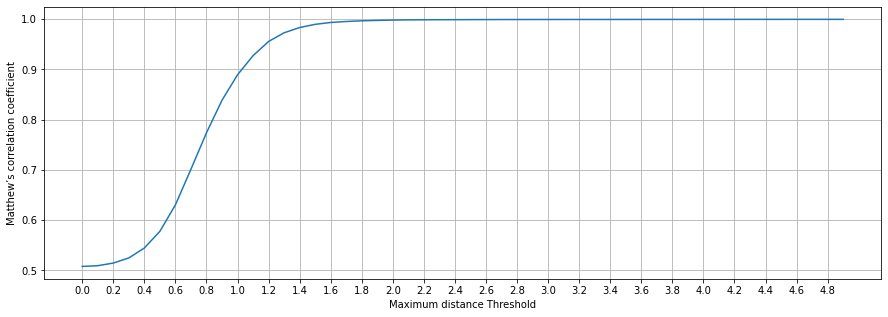

In [1230]:
# plot the scores at each threshold
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0.0, 5, 0.2))
plt.grid(True)
plt.ylabel('Matthew’s correlation coefficient')
plt.xlabel('Maximum distance Threshold')
plt.plot(thresholds, scores);

### We can see that at p2p distance > 1.8, the Matthew’s correlation coefficient barely improves
For simplicity, we can set maximum the p2p distance threshold to 2.

### Crop whole dataset

In [69]:
def recreate_contact_id(game_play, step, player_id_1, player_id_2):
    player_label_2 = player_id_2 if player_id_2 != -1 else 'G'
    contact_id_recreated = f"{game_play}_{step}_{player_id_1}_{player_label_2}"
    
    return contact_id_recreated

In [70]:
class Averager():
    """
    An Averager keeps track of numerical values and returns their average
    """
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [82]:
def compute_yolo_size_avg(contact_df, yolo_model, metadata_df, 
                    view="Endzone", split="Train"):
    """
    Returns the average width and height of all detected persons with the yolo model in the given contact_df and view
    """
    width_averager = Averager()
    height_averager = Averager()
    
    contact_image_df = pd.DataFrame({'contact_id': contact_df['contact_id']})
    contact_image_df['crop_generated'] = False
    # iterate over each unique game_play code
    game_play_list = contact_df['game_play'].unique()
    for game_play in game_play_list:
        # each image from the same game_play code will pertain to the same video
        # load the video pertaining to the game_play
        video_name = f"{game_play}_{view}.mp4"
        videopath = os.path.join(DATASET_DIR, split, video_name)
        cap = cv2.VideoCapture(videopath)
        # iterate over each step from the same game_play
        step_list = contact_df[contact_df['game_play'] == game_play]['step'].unique()
        for step in step_list:
            # set the video capture to the frame pertaining to the step
            frame_number = step_to_frame(game_play, step, metadata_df, view)
            res = False
            while res==False:
                # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
                frame_number = frame_number-1
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                res, frame_image_array = cap.read()
            
            # correct the 1 frame offset
            frame_number = frame_number+1
            # get all the yolo detection boxes and labels
            boxes_yolo, labels_yolo = get_yolo_detections(yolo_model, array_to_image(frame_image_array), 0.3)
            # filter the yolo boxes that have "person" as a predicted label
            boxes_yolo = boxes_yolo[labels_yolo == 'person']
            for box_yolo in boxes_yolo:
                # box format: [xmin, ymin, xmax, ymax]
                width = box_yolo[2] - box_yolo[0]
                height = box_yolo[3] - box_yolo[1]
                width_averager.send(width)
                height_averager.send(height)
            
                
    return width_averager.value, height_averager.value    

In [83]:
def detect_all_data(contact_df, yolo_model, metadata_df, helmet_det_df, tracking_df, 
                    view="Endzone", split="Train", max_rewind=120):
    """
    Detects the players and helmets on all the data and informs where players are not detected
    """
    contact_image_df = pd.DataFrame({'contact_id': contact_df['contact_id']})
    contact_image_df['crop_generated'] = False
    # iterate over each unique game_play code
    game_play_list = contact_df['game_play'].unique()
    for game_play in game_play_list:
        # each image from the same game_play code will pertain to the same video
        # load the video pertaining to the game_play
        video_name = f"{game_play}_{view}.mp4"
        videopath = os.path.join(DATASET_DIR, split, video_name)
        cap = cv2.VideoCapture(videopath)
        # set an auxiliary dataframe with the info from the game_play
        # so that we dont have to find the rows with the given game_play each time
        contact_game_play_df = contact_df[contact_df['game_play'] == game_play]
        helmet_det_game_play_df = helmet_det_df[helmet_det_df['game_play'] == game_play]
        tracking_game_play_df = tracking_df[tracking_df['game_play'] == game_play]
        # iterate over each step from the same game_play
        step_list = contact_game_play_df['step'].unique()
        for step in step_list:
            # set the video capture to the frame pertaining to the step
            frame_number = step_to_frame(game_play, step, metadata_df, view)
            res = False
            while res==False:
                # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
                frame_number = frame_number-1
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                res, frame_image_array = cap.read()
            
            # correct the 1 frame offset
            frame_number = frame_number+1
            # get all the helmet detection boxes and labels
            boxes_helmet, labels_helmet = get_helmet_detections(helmet_det_game_play_df, game_play, 
                                                                frame_number, view)
            # get all the yolo detection boxes and labels
            boxes_yolo, labels_yolo = get_yolo_detections(yolo_model, array_to_image(frame_image_array), 0.3)
            
            # iterate over player_id_1
            player_id_1_list = contact_game_play_df[contact_game_play_df['step'] == step]['nfl_player_id_1'].unique()
            for player_id_1 in player_id_1_list:            
                # iterate over player_id_2
                player_id_2_list = contact_game_play_df[(contact_game_play_df['step'] == step) &
                                              (contact_game_play_df['nfl_player_id_1'] == player_id_1)]['nfl_player_id_2'].unique()
                for player_id_2 in player_id_2_list:
                    # recreate contact_id
                    contact_id_rec = recreate_contact_id(game_play, step, 
                                                         player_id_1, player_id_2)
                    # filter detections of the 2 players
                    boxes_helmet_filt, labels_helmet_filt = filter_helmet_detection(game_play, boxes_helmet, 
                                                                                      labels_helmet, 
                                                                                      [player_id_1, player_id_2], 
                                                                                      tracking_game_play_df)
                    # If no helmets where detected, rewind 10 frames at a time for a maximum of max_rewind frames
                    # and look for helmet detections again
                    rewinded_frames = 0
                    while(len(labels_helmet_filt) == 0 and rewinded_frames < max_rewind):
                        rewinded_frames += 10
                        # detect the helmets on the rewinded frame
                        boxes_helmet_rewind, labels_helmet_rewind = get_helmet_detections(helmet_det_game_play_df, 
                                                                                          game_play, 
                                                                    frame_number-rewinded_frames, view)
                        # filter detections of the 2 players
                        boxes_helmet_filt, labels_helmet_filt = filter_helmet_detection(game_play, 
                                                                                        boxes_helmet_rewind, 
                                                                                        labels_helmet_rewind, 
                                                                                        [player_id_1, player_id_2], 
                                                                                        tracking_game_play_df)
                        
                    # save the number of rewinded frames to the result dataframe
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['rewinded_frames']] = rewinded_frames
                        
                    # save the number of missed helmet detections
                    missed_helmet_dets = 2 - len(labels_helmet_filt) if player_id_2 != -1 else 1 - len(labels_helmet_filt)
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['miss_helmet_dets']] = missed_helmet_dets
                    # get the contact box
                    contact_box, num_det = get_contact_box(boxes_helmet_filt, labels_helmet_filt,
                                                        boxes_yolo, labels_yolo, 
                                                        array_to_image(frame_image_array).size, view)
                    # save the number of missed player detections
                    missed_player_dets = 2 - num_det if player_id_2 != -1 else 1 - num_det
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['miss_player_dets']] = missed_player_dets
                    
                    if len(contact_box) != 0:
                        # crop the image
                        cropped_image_array = frame_image_array[contact_box[1]:contact_box[3], # y coordinates
                                                                contact_box[0]:contact_box[2]] # x coordinates
                        cropped_image = array_to_image(cropped_image_array)
                        # save the cropped image
                        crop_name = f"{contact_id_rec}_{view}.jpg"
                        cropped_image.save(os.path.join(DATASET_DIR, split, 'crops', crop_name))
                        contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['crop_generated']] = True

                
    return contact_image_df        

In [95]:
def show_contact_crop_results(contact_image_df, contact_df):
    # Check the results from the contact image cropping
    print(f"Total crops generated: {contact_image_df['crop_generated'].sum()}")
    print(f"Total crops NOT generated: {len(contact_image_df) - contact_image_df['crop_generated'].sum()}")
    print(f"% of crops generated: {(contact_image_df['crop_generated'].sum() / len(contact_image_df))*100:.2f}%")

    print("\n")
    rew = len(contact_image_df[(contact_image_df['rewinded_frames'] > 0) & 
                                (contact_image_df['crop_generated']) == True])
    rew_1_30 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=30) & 
                                     (contact_image_df['rewinded_frames'] >0)])
    rew_31_60 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=60) & 
                                     (contact_image_df['rewinded_frames'] >30)])
    rew_61_90 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=90) & 
                                     (contact_image_df['rewinded_frames'] >60)])
    rew_91_120 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=120) & 
                                      (contact_image_df['rewinded_frames'] >90) & 
                                      (contact_image_df['crop_generated']) == True])
    print(f"Total crops generated by rewinding: {rew}, {(rew / contact_image_df['crop_generated'].sum())*100:.2f}% of total crops")
    print(f"Total crops generated by rewinding between 1 and 30 frames: {rew_1_30}, {(rew_1_30/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 31 and 60 frames: {rew_31_60}, {(rew_31_60/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 61 and 90 frames: {rew_61_90}, {(rew_61_90/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 91 and 120 frames: {rew_91_120}, {(rew_91_120/rew)*100:.2f}% of rewinded crops")

    print("\n")
    print(f"Total helmet detection misses: {contact_image_df['miss_helmet_dets'].sum().astype(int)}")
    print(f"Total player detection misses: {contact_image_df['miss_player_dets'].sum().astype(int)}")

    print("\n")
    helmet_player_misses = contact_image_df[(contact_image_df['miss_helmet_dets'] == 2) & 
                                            (contact_df["nfl_player_id_2"] != -1)]
    print(f"Total complete helmet misses of 2 player contact: {len(helmet_player_misses)}, {(len(helmet_player_misses) / len(contact_image_df))*100:.2f}%")
    helmet_ground_misses = contact_image_df[(contact_image_df['miss_helmet_dets'] == 1) & 
                                            (contact_df["nfl_player_id_2"] == -1)]
    print(f"Total complete helmet misses of ground contact: {len(helmet_ground_misses)}, {(len(helmet_ground_misses) / len(contact_image_df))*100:.2f}%")
    len_misses_total = len(helmet_player_misses) + len(helmet_ground_misses)
    print(f"2 player helmet misses + ground misses : {len_misses_total}, {len_misses_total / len(contact_image_df)*100:.2f}%")

    num_p2p_contacts = (contact_df["nfl_player_id_2"] != -1).sum()
    num_ground_contacts = (contact_df["nfl_player_id_2"] == -1).sum()

    print("\n")
    print(f"Total p2p contacts: {num_p2p_contacts}, {num_p2p_contacts / len(contact_image_df)*100:.2f}%")
    print(f"From which, {(len(helmet_player_misses) / num_p2p_contacts)*100:.2f}% were complete helmet p2p misses")
    print(f"Total ground contacts: {num_ground_contacts}, {num_ground_contacts / len(contact_image_df)*100:.2f}%")
    print(f"From which, {(len(helmet_ground_misses) / num_ground_contacts)*100:.2f}% were complete helmet ground misses")

    print("\n")
    miss_dif_p2p = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & 
                          (contact_df["nfl_player_id_2"] != -1) &
                          (contact_image_df['miss_helmet_dets'] ==0)]
    miss_dif_ground = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & 
                          (contact_df["nfl_player_id_2"] == -1) &
                          (contact_image_df['miss_helmet_dets'] ==0)]
    miss_1 = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & (contact_df["nfl_player_id_2"] != -1) &
          (contact_image_df['miss_helmet_dets'] !=0)]
    print(f"Player detection misses (1 or 2) where helmet detections dont miss (no ground): {len(miss_dif_p2p)}, {(len(miss_dif_p2p) / len(contact_image_df))*100:.2f}%")
    print(f"Player detection misses (1 or 2) where helmet detections miss 1 (no ground): {len(miss_1)}, {(len(miss_1) / len(contact_image_df))*100:.2f}%")
    print(f"Player detection misses (1 or 2) where helmet detections dont miss (ground): {len(miss_dif_ground)}, {(len(miss_dif_ground) / len(contact_image_df))*100:.2f}%")


In [86]:
MAX_DISTANCE_THRS = 2
# filter the contacts with p2p distance < MAX_DISTANCE_THRS and contacts with the floor
train_contact_df_reduced = train_contact_df[(train_contact_df['p2p_distance'] < MAX_DISTANCE_THRS) | 
                                            (train_contact_df['nfl_player_id_2'] == -1)]
train_contact_df_reduced.to_csv(os.path.join(DATASET_DIR, "train_contact_df_reduced.csv"), index=False)
train_contact_df_reduced

contact_id     game_play  step  nfl_player_id_1  \
10       58168_003392_0_38590_44822  58168_003392     0            38590   
11       58168_003392_0_38590_39947  58168_003392     0            38590   
13       58168_003392_0_38590_42565  58168_003392     0            38590   
50       58168_003392_0_41944_42565  58168_003392     0            41944   
119      58168_003392_0_37211_46445  58168_003392     0            37211   
...                             ...           ...   ...              ...   
4721613     58582_003121_91_48220_G  58582_003121    91            48220   
4721614     58582_003121_91_47906_G  58582_003121    91            47906   
4721615     58582_003121_91_38557_G  58582_003121    91            38557   
4721616     58582_003121_91_47872_G  58582_003121    91            47872   
4721617     58582_003121_91_52619_G  58582_003121    91            52619   

         nfl_player_id_2  ...  orientation_2  acceleration_2  sa_2  \
10                 44822  ...         128.82            2.45  2.43   
11                 39947  ...          90.69            1.68  1.64   
13                 42565  ...          94.13            1.55  1.54   
50                 42565  ...          94.13            1.55  1.54   
119                46445  ...          92.39            2.03  2.03   
...                  ...  ...            ...             ...   ...   
4721613               -1  ...           0.00            0.00  0.00   
4721614               -1  ...           0.00            0.00  0.00   
4721615               -1  ...           0.00            0.00  0.00   
4721616               -1  ...           0.00            0.00  0.00   
4721617               -1  ...           0.00            0.00  0.00   

        p2p_distance contact_truth  
10          1.833712             0  
11          1.466595             0  
13          1.897077             0  
50          1.378006             0  
119         1.258014             0  
...              ...           ...  
4721613   999.000000             0  
4721614   999.000000             0  
4721615   999.000000             0  
4721616   999.000000             0  
4721617   999.000000             0  

[660541 rows x 32 columns]

In [87]:
# load yolo model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\AT016638/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-2 Python-3.7.15 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### Compute average box sizes

In [1468]:
# train labels
# MAX_DISTANCE_THRS = 2
# contact_df = preprocess_input(train_labels_df, train_player_tracking_df)
# # filter the contacts with p2p distance < MAX_DISTANCE_THRS and contacts with the floor
# contact_df_reduced = contact_df[(contact_df['p2p_distance'] < MAX_DISTANCE_THRS) | (contact_df['nfl_player_id_2'] == -1)]
# contact_df_reduced

In [1410]:
# # compute average person box size
# # endzone
# start_time = time.time()
# avg_with_endzone, avg_height_endzone = compute_yolo_size_avg(contact_df_reduced, yolo_model, 
#                                                              train_video_metadata_df, 
#                                                              "Endzone", "train")
# end_time = time.time()
# print(f"computing average box sizes (Endzone) finished after {(end_time - start_time):.2f} seconds")
# # sideline
# start_time = time.time()
# avg_with_sideline, avg_height_sideline = compute_yolo_size_avg(contact_df_reduced, yolo_model, 
#                                                              train_video_metadata_df, 
#                                                              "Sideline", "train")
# end_time = time.time()
# print(f"computing average box sizes (Sideline) finished after {(end_time - start_time):.2f} seconds")

# print("\n")
# print(f"Average person box sizes in Endzone: width: {avg_with_endzone:.2f}, height: {avg_height_endzone:.2f}")
# print(f"Average person box sizes in Sideline: width: {avg_with_sideline:.2f}, height: {avg_height_sideline:.2f}")

computing average box sizes (Endzone) finished after 5189.80 seconds
computing average box sizes (Sideline) finished after 5315.04 seconds


Average person box sizes in Endzone: width: 70.66, height: 130.21
Average person box sizes in Sideline: width: 40.05, height: 80.55


Train split:

Average person box sizes in Endzone: width: 70.66, height: 130.21

Average person box sizes in Sideline: width: 40.05, height: 80.55

Test split:

Average person box sizes in Endzone: width: 52.36, height: 98.55

Average person box sizes in Sideline: width: 43.02, height: 83.06

### Crop contact images

In [88]:
# create crops folder
crops_folder = os.path.join(DATASET_DIR, 'train', 'crops')
!mkdir {crops_folder}
crops_folder = os.path.join(DATASET_DIR, 'test', 'crops')
!mkdir {crops_folder}

A subdirectory or file dataset\train\crops already exists.
A subdirectory or file dataset\test\crops already exists.


In [89]:
# test split
# endzone
start_time = time.time()
contact_image_endzone_df = detect_all_data(train_contact_df_reduced, yolo_model, train_video_metadata_df, 
                                           train_helmet_detection_df, train_player_tracking_df, "Endzone", "train")
end_time = time.time()
print(f"Contact image cropping finished after {(end_time - start_time):.2f} seconds")
contact_image_endzone_df.to_csv(os.path.join(DATASET_DIR, "train_contact_image_endzone_df.csv"), index=False)
contact_image_endzone_df

Contact image cropping finished after 166964.62 seconds


contact_id  crop_generated  rewinded_frames  \
10       58168_003392_0_38590_44822            True              0.0   
11       58168_003392_0_38590_39947            True              0.0   
13       58168_003392_0_38590_42565            True              0.0   
50       58168_003392_0_41944_42565            True              0.0   
119      58168_003392_0_37211_46445            True              0.0   
...                             ...             ...              ...   
4721613     58582_003121_91_48220_G           False            120.0   
4721614     58582_003121_91_47906_G           False            120.0   
4721615     58582_003121_91_38557_G           False            120.0   
4721616     58582_003121_91_47872_G            True             10.0   
4721617     58582_003121_91_52619_G           False            120.0   

         miss_helmet_dets  miss_player_dets  
10                    0.0               0.0  
11                    0.0               0.0  
13                    0.0               0.0  
50                    0.0               0.0  
119                   0.0               0.0  
...                   ...               ...  
4721613               1.0               1.0  
4721614               1.0               1.0  
4721615               1.0               1.0  
4721616               0.0               0.0  
4721617               1.0               1.0  

[660541 rows x 5 columns]

In [96]:
show_contact_crop_results(contact_image_endzone_df, train_contact_df_reduced)

Total crops generated: 562471
Total crops NOT generated: 98070
% of crops generated: 85.15%


Total crops generated by rewinding: 77710, 13.82% of total crops
Total crops generated by rewinding between 1 and 30 frames: 32683, 42.06% of rewinded crops
Total crops generated by rewinding between 31 and 60 frames: 18051, 23.23% of rewinded crops
Total crops generated by rewinding between 61 and 90 frames: 14606, 18.80% of rewinded crops
Total crops generated by rewinding between 91 and 120 frames: 12370, 15.92% of rewinded crops


Total helmet detection misses: 144979
Total player detection misses: 226876


Total complete helmet misses of 2 player contact: 12649, 1.91%
Total complete helmet misses of ground contact: 85421, 12.93%
2 player helmet misses + ground misses : 98070, 14.85%


Total p2p contacts: 249908, 37.83%
From which, 5.06% were complete helmet p2p misses
Total ground contacts: 410633, 62.17%
From which, 20.80% were complete helmet ground misses


Player detection misses (1 o

In [1476]:
# sideline
start_time = time.time()
contact_image_sideline_df = detect_all_data(contact_df_reduced, yolo_model, test_video_metadata_df, 
                                   test_helmet_detection_df, test_player_tracking_df, "Sideline", "test")
end_time = time.time()
print(f"Contact image cropping finished after {(end_time - start_time):.2f} seconds")
contact_image_df

Contact image cropping finished after 313.80 seconds


contact_id  crop_generated  rewinded_frames  \
10     58168_003392_0_38590_44822            True              0.0   
11     58168_003392_0_38590_39947            True              0.0   
13     58168_003392_0_38590_42565            True              0.0   
50     58168_003392_0_41944_42565            True              0.0   
119    58168_003392_0_37211_46445            True              0.0   
...                           ...             ...              ...   
49583    58172_003247_125_40656_G            True              0.0   
49584    58172_003247_125_52521_G            True             90.0   
49585    58172_003247_125_52939_G            True              0.0   
49586    58172_003247_125_39008_G            True             40.0   
49587    58172_003247_125_47912_G            True             30.0   

       miss_helmet_dets  miss_player_dets  
10                  0.0               2.0  
11                  0.0               2.0  
13                  0.0               2.0  
50                  0.0               1.0  
119                 0.0               2.0  
...                 ...               ...  
49583               0.0               1.0  
49584               0.0               1.0  
49585               0.0               0.0  
49586               0.0               1.0  
49587               0.0               1.0  

[6631 rows x 5 columns]

In [1477]:
show_contact_crop_results(contact_image_sideline_df)

Total crops generated: 6588
Total crops NOT generated: 43
% of crops generated: 99.35%


Total crops generated by rewinding: 369, 5.60% of total crops
Total crops generated by rewinding between 1 and 30 frames: 205, 55.56% of rewinded crops
Total crops generated by rewinding between 31 and 60 frames: 64, 17.34% of rewinded crops
Total crops generated by rewinding between 61 and 90 frames: 52, 14.09% of rewinded crops
Total crops generated by rewinding between 91 and 120 frames: 48, 13.01% of rewinded crops


Total helmet detection misses: 135
Total player detection misses: 4872


Total complete helmet misses of 2 player contact: 2, 0.03%
Total complete helmet misses of ground contact: 41, 0.62%
2 player helmet misses + ground misses : 43, 0.65%


Total p2p contacts: 2319, 34.97%
From which, 0.09% were complete helmet p2p misses
Total ground contacts: 4312, 65.03%
From which, 0.95% were complete helmet ground misses


Player detection misses (1 or 2) where helmet detections dont miss (n

In [1364]:
contact_image_endzone_df[contact_image_endzone_df['contact_id'] == '58168_003392_27_40011_G']

contact_id  crop_generated  rewinded_frames  \
7082  58168_003392_27_40011_G            True             10.0   

      miss_helmet_dets  miss_player_dets  
7082               0.0               1.0

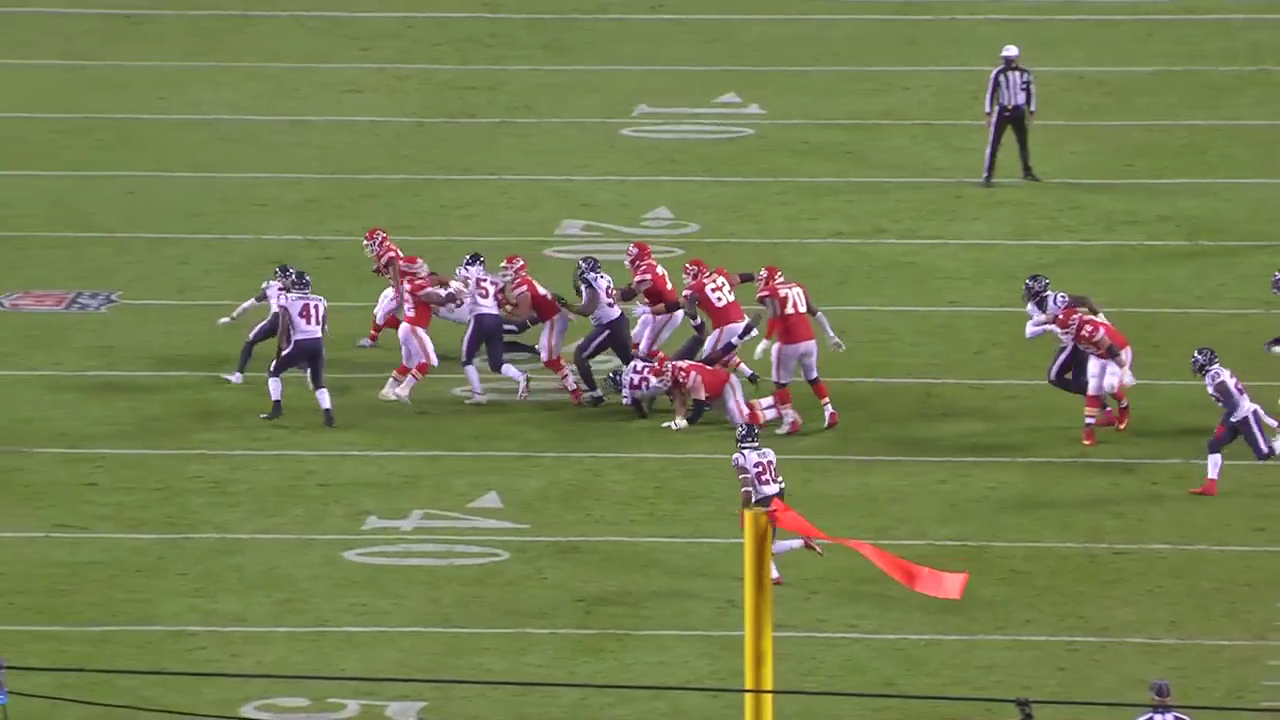

In [1390]:
frame_number = step_to_frame("58168_003392", 27, train_video_metadata_df, 'Endzone')
array_to_image(get_video_frame("58168_003392", frame_number, 'Endzone', "test")[0])

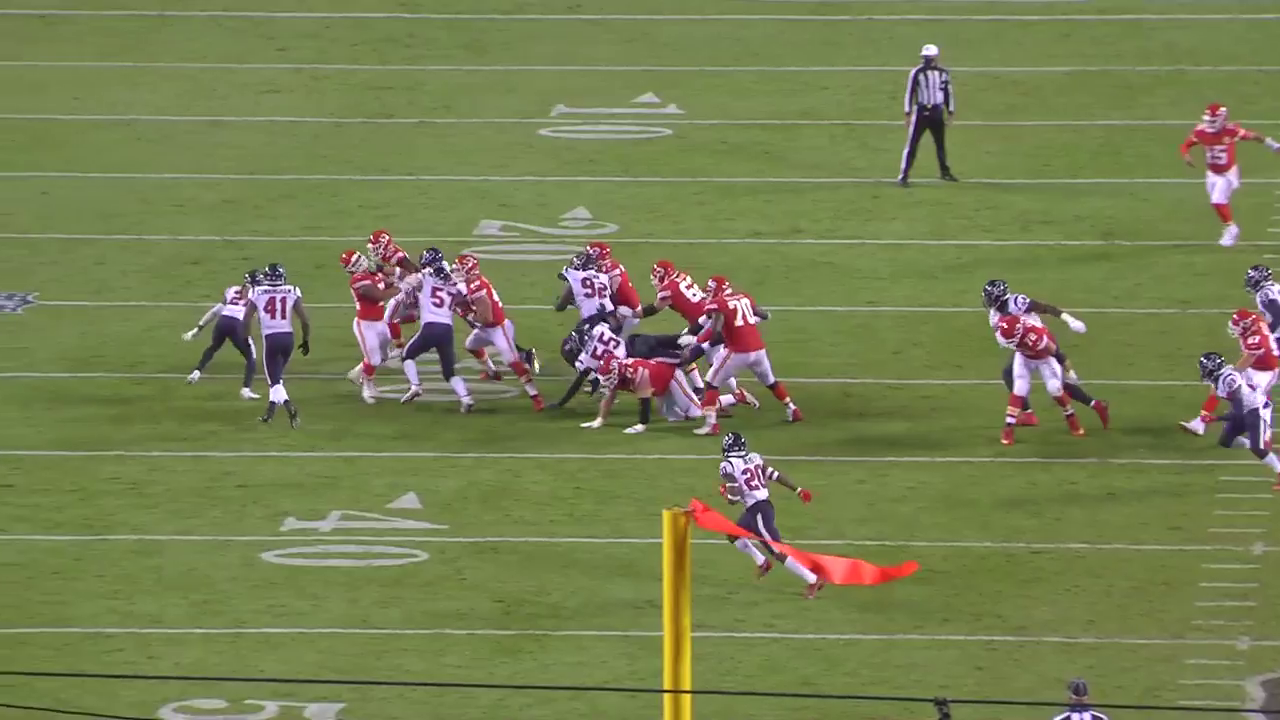

In [1391]:
array_to_image(get_video_frame("58168_003392", frame_number-10, 'Endzone', "test")[0])

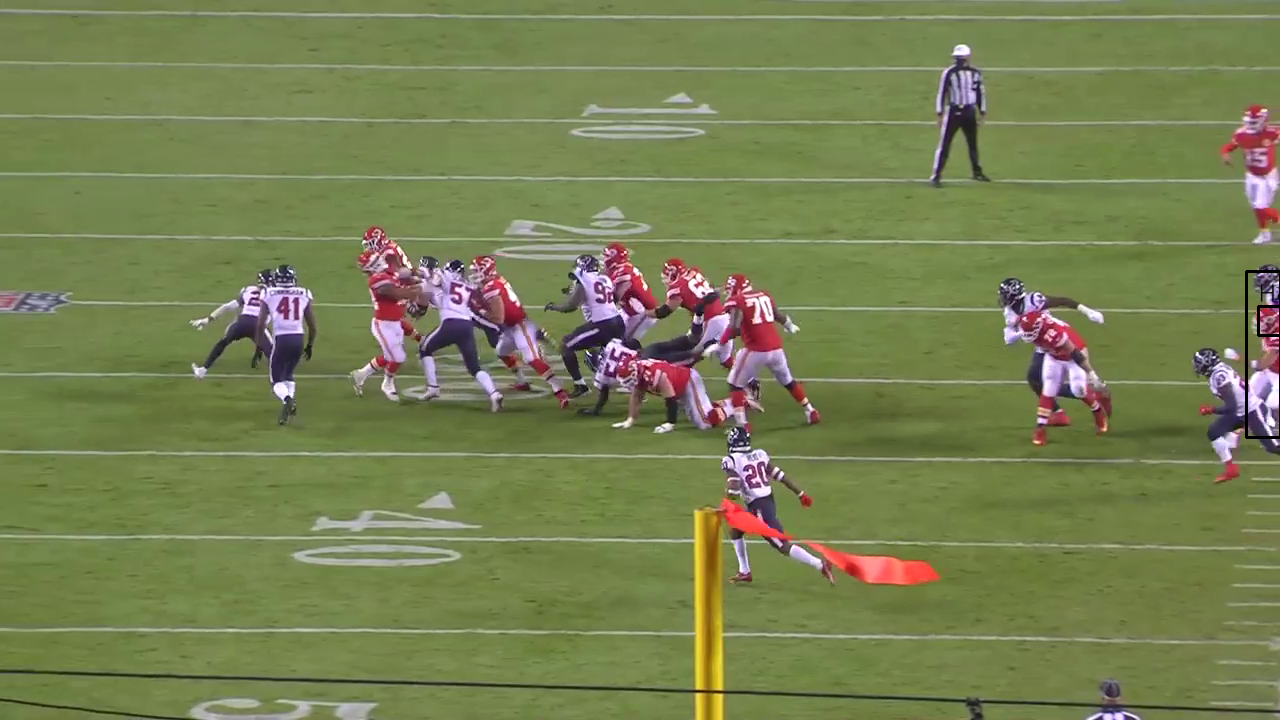

In [1388]:
array_to_image(get_contact_image("58168_003392", 40011, -1, 26, yolo_model, 
                   test_video_metadata_df, test_helmet_detection_df, 
                   test_player_tracking_df, 'Endzone', 'test', crop=False))

In [1395]:
contact_image_endzone_df[(contact_image_endzone_df['rewinded_frames'] <=60) & 
                                     (contact_image_endzone_df['rewinded_frames'] >30)]

contact_id  crop_generated  rewinded_frames  \
3016   58168_003392_11_41257_G            True             40.0   
3269   58168_003392_12_41257_G            True             40.0   
8342   58168_003392_32_44822_G            True             40.0   
8347   58168_003392_32_40011_G            True             40.0   
8595   58168_003392_33_44822_G            True             40.0   
...                        ...             ...              ...   
20742  58172_003247_11_52521_G            True             60.0   
32365  58172_003247_57_43406_G            True             60.0   
35651  58172_003247_70_41937_G            True             40.0   
35904  58172_003247_71_41937_G            True             50.0   
36157  58172_003247_72_41937_G            True             40.0   

       miss_helmet_dets  miss_player_dets  
3016                0.0               1.0  
3269                0.0               0.0  
8342                0.0               0.0  
8347                0.0               0.0  
8595                0.0               1.0  
...                 ...               ...  
20742               0.0               1.0  
32365               0.0               1.0  
35651               0.0               0.0  
35904               0.0               0.0  
36157               0.0               0.0  

[68 rows x 5 columns]

In [ ]:
# contacts where different misses between helmets and players (no ground)
result[(result['miss_helmet_dets'] != result['miss_player_dets']) & (contact_df_reduced["nfl_player_id_2"] != -1)]

In [1412]:
# missed floor contact detections
result[(contact_df_reduced['nfl_player_id_2'] == -1) &
      (result["miss_player_dets"] > 0)]

contact_id  crop_generated  miss_helmet_dets  \
238      58168_003392_0_47837_G           False               1.0   
252      58168_003392_0_46522_G           False               1.0   
491      58168_003392_1_47837_G           False               1.0   
505      58168_003392_1_46522_G           False               1.0   
744      58168_003392_2_47837_G           False               1.0   
...                         ...             ...               ...   
49576  58172_003247_125_45005_G            True               0.0   
49578  58172_003247_125_48241_G            True               0.0   
49582  58172_003247_125_44965_G            True               0.0   
49583  58172_003247_125_40656_G            True               0.0   
49587  58172_003247_125_47912_G            True               0.0   

       miss_player_dets  
238                 1.0  
252                 1.0  
491                 1.0  
505                 1.0  
744                 1.0  
...                 ...  
49576               1.0  
49578               1.0  
49582               1.0  
49583               1.0  
49587               1.0  

[871 rows x 4 columns]

## Submission

In [ ]:
# # load the submission dataframe
# input_df = pd.read_csv(os.path.join(DATASET_DIR, "sample_submission.csv"))

# THRES = 1.1

# contact_df = preprocess_input(input_df, test_player_tracking_df)
# # contact_df = add_ground_truth_data(contact_df, train_labels_df)
# contact_df['contact'] = (contact_df['p2p_distance'] < THRES).astype(int)


# submission = contact_df[["contact_id", "contact"]].copy()
# submission['contact'] = submission['contact'].fillna(0).astype('int')
# submission[["contact_id", "contact"]].to_csv("submission.csv", index=False)

# submission